In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from itertools import chain
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Set Parameters
im_width = 256
im_height = 256


# **Loading image's path and mask's path**

In [3]:
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
rain_files = []
mask_files = glob('C:\Users\srira\Downloads\input\lgg-mri-segmentation\*\*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:2])
print(mask_files[:2])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif']


# **Data Visualization**

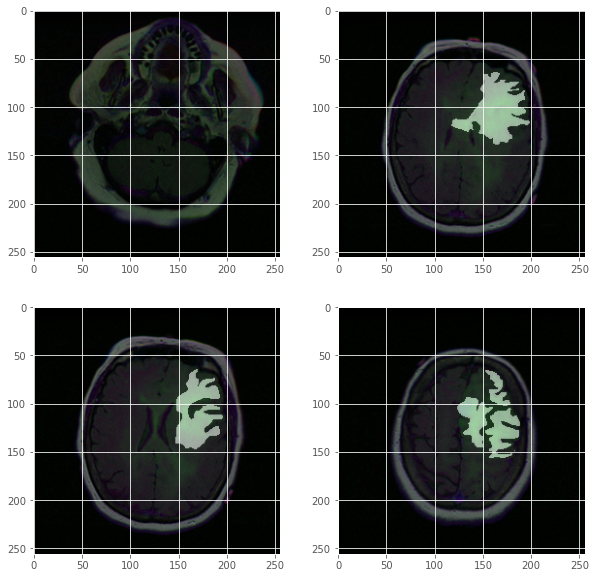

In [5]:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import labelrows,cols=2,2
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.5)
plt.show()

# **Dataframe creation and splitting data into train,validation and test sets **

In [19]:
from sklearn.model_selection import train_test_splitdf = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.15)
df_train, df_val = train_test_split(df_train,test_size = 0.25)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2504, 2)
(835, 2)
(590, 2)


# **Data genertator, data augmentation and scaling data**

In [20]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# loss function 

In [21]:
epslon=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + epslon) / (K.sum(y_truef) + K.sum(y_predf) + epslon))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + epslon) / (sum_ - intersection + epslon)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

#  Unet

In [22]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [23]:
model = unet()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 256, 256, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 256, 256, 64) 0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 64) 36928       activation_90[0][0]              
____________________________________________________________________________________________

# **Training**

In [24]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

In [25]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2504 validated image filenames.
Found 2504 validated image filenames.
Epoch 1/50
79/78 [==============================] - ETA: -1s - loss: -0.1447 - binary_accuracy: 0.9512 - iou: 0.0808 - dice_coef: 0.1461Found 835 validated image filenames.
Found 835 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02420, saving model to unet_brain_mri_seg.hdf5
79/78 [==============================] - 123s 2s/step - loss: -0.1447 - binary_accuracy: 0.9512 - iou: 0.0808 - dice_coef: 0.1461 - val_loss: -0.0242 - val_binary_accuracy: 0.7971 - val_iou: 0.0121 - val_dice_coef: 0.0237
Epoch 2/50
79/78 [==============================] - ETA: 0s - loss: -0.2542 - binary_accuracy: 0.9880 - iou: 0.1479 - dice_coef: 0.2536
Epoch 00002: val_loss did not improve from -0.02420
79/78 [==============================] - 82s 1s/step - loss: -0.2542 - binary_accuracy: 0.9880 - iou: 0.1479 - dice_coef: 0.2536 - val_loss: -0.0188 - val_binary_accuracy: 0.9904 - val_iou: 0.0097 - val_dice_co

79/78 [==============================] - 87s 1s/step - loss: -0.8206 - binary_accuracy: 0.9972 - iou: 0.7011 - dice_coef: 0.8203 - val_loss: -0.8321 - val_binary_accuracy: 0.9973 - val_iou: 0.7074 - val_dice_coef: 0.8183
Epoch 20/50
79/78 [==============================] - ETA: 0s - loss: -0.8207 - binary_accuracy: 0.9972 - iou: 0.7029 - dice_coef: 0.8206
Epoch 00020: val_loss did not improve from -0.83210
79/78 [==============================] - 87s 1s/step - loss: -0.8207 - binary_accuracy: 0.9972 - iou: 0.7029 - dice_coef: 0.8206 - val_loss: -0.7977 - val_binary_accuracy: 0.9974 - val_iou: 0.6799 - val_dice_coef: 0.8026
Epoch 21/50
79/78 [==============================] - ETA: 0s - loss: -0.8211 - binary_accuracy: 0.9970 - iou: 0.7014 - dice_coef: 0.8203
Epoch 00021: val_loss did not improve from -0.83210
79/78 [==============================] - 88s 1s/step - loss: -0.8211 - binary_accuracy: 0.9970 - iou: 0.7014 - dice_coef: 0.8203 - val_loss: -0.8003 - val_binary_accuracy: 0.9968 -

Epoch 39/50
79/78 [==============================] - ETA: 0s - loss: -0.8577 - binary_accuracy: 0.9973 - iou: 0.7562 - dice_coef: 0.8585
Epoch 00039: val_loss did not improve from -0.87589
79/78 [==============================] - 82s 1s/step - loss: -0.8577 - binary_accuracy: 0.9973 - iou: 0.7562 - dice_coef: 0.8585 - val_loss: -0.8656 - val_binary_accuracy: 0.9978 - val_iou: 0.7663 - val_dice_coef: 0.8624
Epoch 40/50
79/78 [==============================] - ETA: 0s - loss: -0.8647 - binary_accuracy: 0.9975 - iou: 0.7666 - dice_coef: 0.8647
Epoch 00040: val_loss did not improve from -0.87589
79/78 [==============================] - 82s 1s/step - loss: -0.8647 - binary_accuracy: 0.9975 - iou: 0.7666 - dice_coef: 0.8647 - val_loss: -0.8014 - val_binary_accuracy: 0.9967 - val_iou: 0.6803 - val_dice_coef: 0.8047
Epoch 41/50
79/78 [==============================] - ETA: 0s - loss: -0.8681 - binary_accuracy: 0.9975 - iou: 0.7738 - dice_coef: 0.8689
Epoch 00041: val_loss did not improve from 

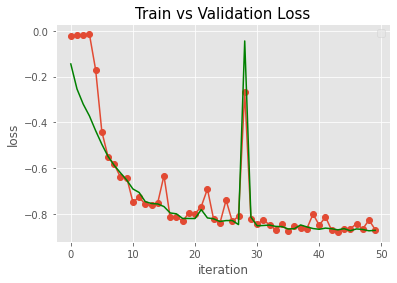

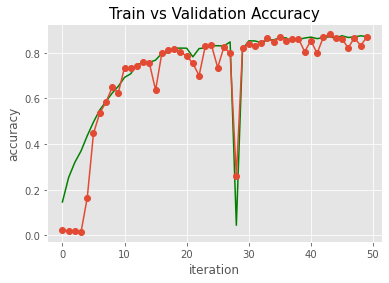

In [41]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'o-')
plt.plot(list_trainloss,'g-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train vs Validation Loss', fontsize = 15)
plt.legend()
plt.figure(2)
plt.plot(list_traindice, 'g-')
plt.plot(list_testdice, 'o-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('Train vs Validation Accuracy', fontsize = 15)
plt.show()

In [36]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

# **Testing**

In [37]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
19/18 [==============================] - 10s 545ms/step - loss: -0.8690 - binary_accuracy: 0.9976 - iou: 0.7733 - dice_coef: 0.8700
Test lost:  -0.8689586520195007
Test IOU:  0.9975677132606506
Test Dice Coefficent:  0.7732557058334351


# Results

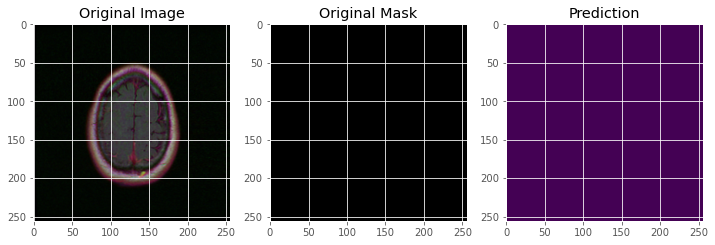

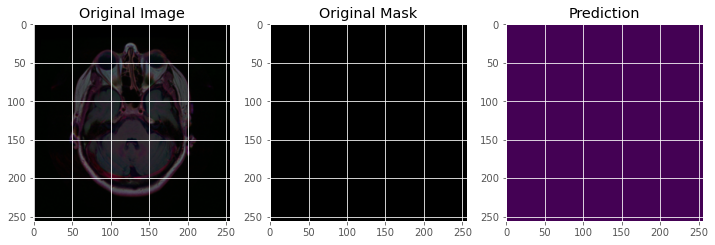

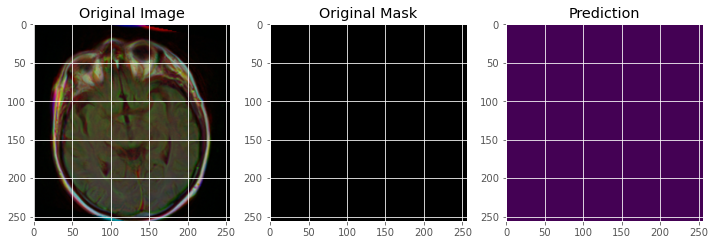

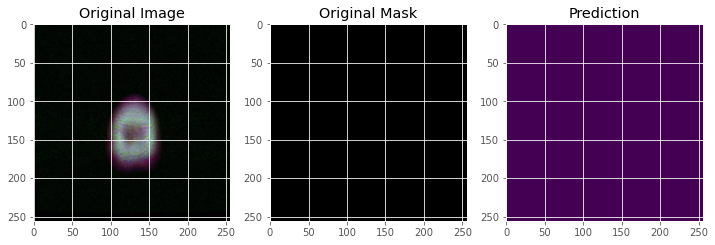

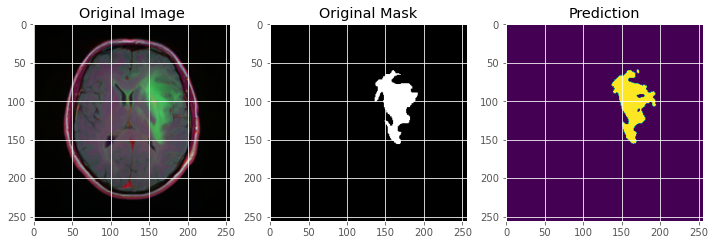

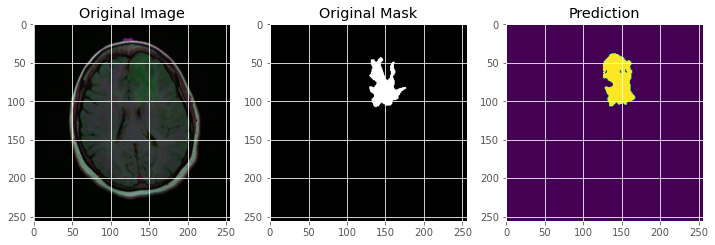

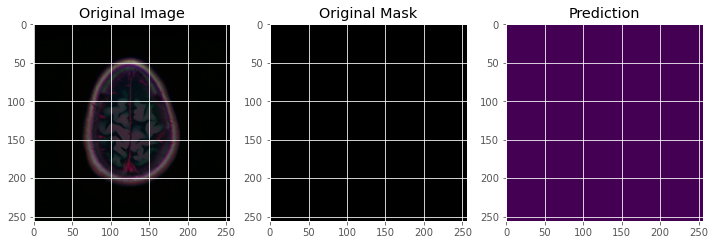

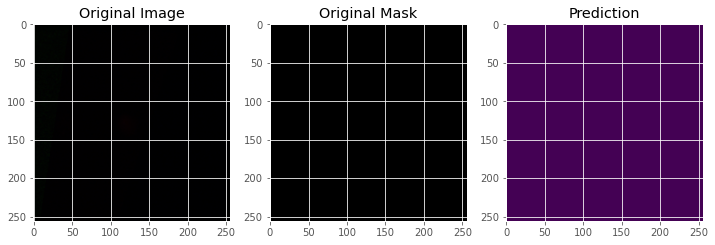

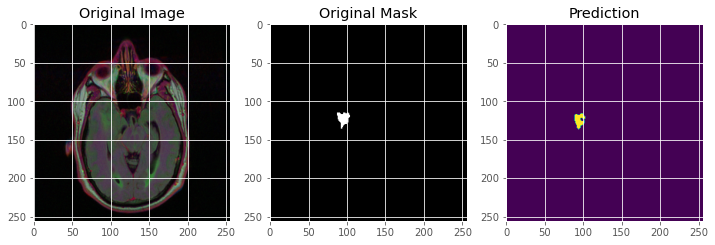

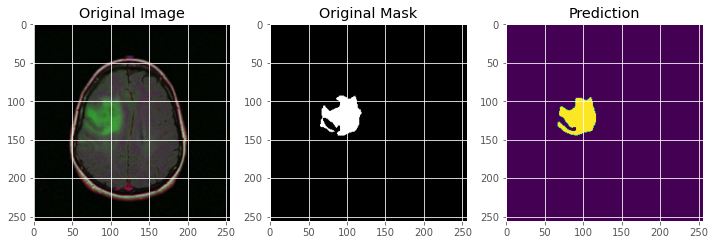

In [39]:
for i in range(50,60):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()